# Model System Notebook 3: NRSS

Notebook 3 covers how we build an NRSS model to simulate RSoXS. A random sequential addition (RSA) algorithm is used to build up the system of multi-walled carbon nanotubes (MWCNTs), which is then converted into an NRSS model and simulated.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import xarray as xr
from fiberRSA.fiberRSA import create_random_CNT, create_all_CNT, upscale_all_CNTs, dilate_all_par, dilate_all_par_hollow, find_angles

## Random Sequential Addition

The Random Sequential Addition algorithm:
1. Choose distributions for MWCNT orientation, radius, and length. Additional parameters that can be set are hollow fraction of the tube, and box dimensions in X, Y, and Z.
2. A test MWCNT is created by sampling from the distributions in orientation, radius, and length, and randomly placing it inside the morphology.
3. Overlap is tested between the test MWCNT and all other MWCNTs already in the morphology.
4. If there is no overlap, the MWCNT is added to the list of placed MWCNTs. If there is overlap, the test MWCNT is discarded.
5. Repeat steps 2-4 for N trials, or until the morphology reaches a threshold MWCNT density.

Steps 1-5 are encapsulted in the function `create_all_CNT`. We have chosen a log-normal distribution for MWCNT radius, a uniform distribution for length, and gaussian distributions for the two Euler angles, psi and theta. Values to define specific instances of those distributions are input parameters for `create_all_CNT`. The base function that achieves Step 2 is `create_random_CNT`. To illustrate the base function, we can choose values for `BoxXY`, `BoxZ`, `theta`, `psi`, `length`, and `radius` and call the function once to create a single CNT object

In [71]:
BoxXY = 512
BoxZ = 128
theta = np.random.random()*np.pi/2
psi = np.random.random()*np.pi*2
length = 100
radius = 2
single_CNT = create_random_CNT(BoxXY, BoxZ, theta, psi, length, radius)

Creating a single CNT with random orientation, we can see the object an instance of the CNT class, which itself is a Numba jitclass. Numba compiles the class to speed up compute.

In [72]:
single_CNT

We can plot the xyz values for each point sampled along the MWCNT central axis

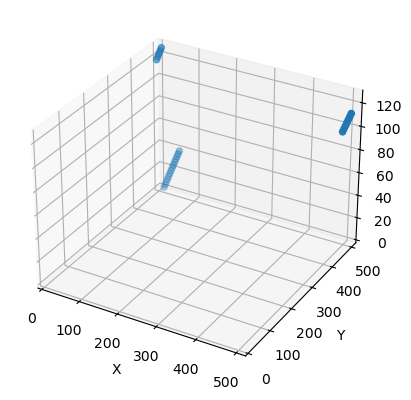

In [73]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(single_CNT.x, single_CNT.y, single_CNT.z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,512)
ax.set_ylim(0,512)
ax.set_zlim(0,128)
plt.show()

`create_random_CNT` is called within `create_all_CNT` for each trial insertion of a new MWCNT. Here we attempt to insert 1000 CNTs into the box.

In [75]:
BoxXY = 512
BoxZ = 128
num_trials = 1000
radius_mu = 2.32
radius_sigma = 0.275
theta_mu = np.pi/2
theta_sigma = 0.2
length_lower = 75
length_upper = 300
all_CNTs = create_all_CNT(num_trials, radius_mu, radius_sigma, theta_mu, theta_sigma, length_lower, length_upper, BoxXY, BoxZ)

In [76]:
len(all_CNTs)

93

For 1000 trials, we were only able to successfully place 96 CNTs into the box; a success rate of 9.6%. The success rate will continue to go down as we pack more CNTs into a box. Plotting the list of CNTs returned by `create_all_CNTs`, we can see the CNTs are contained within the 128x512x512 (ZYX) box. If you look closely, you can see CNTs that hit the edge of the box and wrap around to the other side due to the periodic boundary conditions.

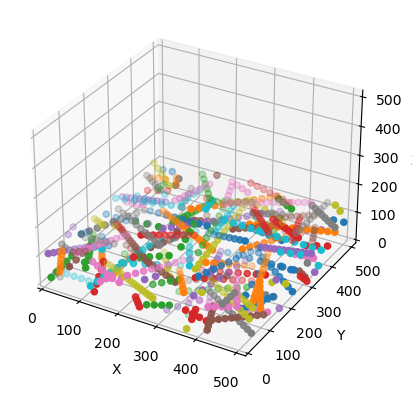

In [78]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for CNT in all_CNTs:
    ax.scatter(CNT.x, CNT.y, CNT.z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(0,512)
ax.set_ylim(0,512)
ax.set_zlim(0,512)
plt.show()

The next step is to take the list of CNTs, each of which contain a list of coordinates, and translate them into a 3D voxel-based array. To do that, we upscale the sampling of coordinates and perform a dilation operation. The CNT coordinates were sampled at a lower resolution for trial placements to make the intersection algorithm more efficient.

In [79]:
upscale_all_CNTs(all_CNTs, BoxXY, BoxZ)

hollow_fraction = 0.5
CNTs_dilated = np.zeros((BoxZ, BoxXY, BoxXY))
dilate_all_par_hollow(all_CNTs, CNTs_dilated, BoxXY, BoxZ, hollow_fraction, inside_value=0)

We can plot a slice of the dilated array to show how the CNT central axis locations have been translated into the 3D voxel array. `dilate_all_par_hollow` does two dilation operations. The first creates a solid CNT with value 1. The second dilation operation goes back and assigns a value of zero to the interior of the CNT corresponding to radius*hollow_fraction.

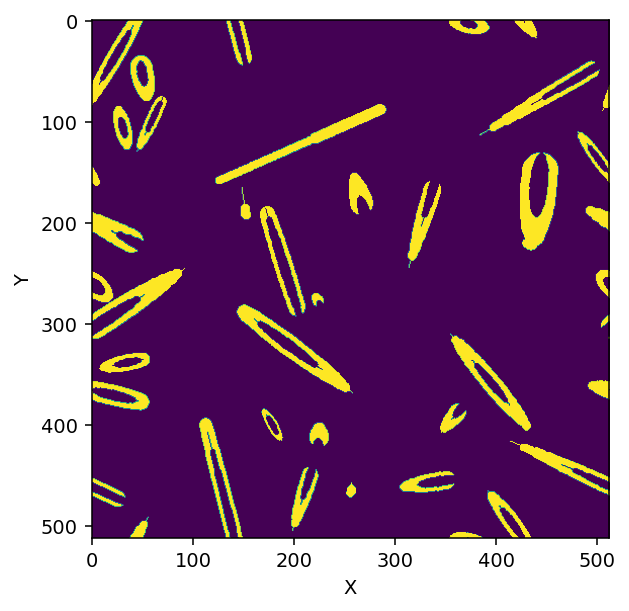

In [83]:
plt.figure(dpi=140)
plt.imshow(CNTs_dilated[64,...])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

We can also sum up along the z-axis to plot a projection of the 3D voxel array.

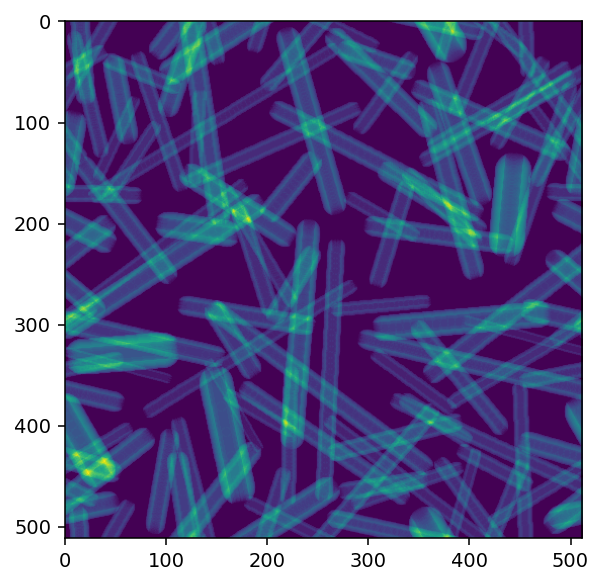

In [81]:
plt.figure(dpi=140)
plt.imshow(np.sum(CNTs_dilated, axis=0))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [2]:
sys.path.append('/home/pjd/lib/NRSS/src')

In [3]:
from NRSS.visualizer import morphology_visualizer

In [4]:
def Rz(angle):
    return np.array([[np.cos(angle), -np.sin(angle), 0],
                     [np.sin(angle), np.cos(angle), 0],
                     [0, 0, 1]])

def Ry(angle):
    return np.array([[np.cos(angle), 0, np.sin(angle)],
                    [0, 1, 0],
                    [-np.sin(angle), 0, np.cos(angle)]])


def create_R(theta, psi):
    rz = Rz(psi)
    ry = Ry(theta)
    return rz@ry


def create_uni_tensor(delta_ord, beta_ord, delta_ex, beta_ex):
    uni_tensor = np.zeros((delta_ord.shape[0], 3,3), dtype=complex)
    for i in range(len(uni_tensor)):
        uni_tensor[i, 0, 0] = complex(1-delta_ord[i], beta_ord[i])
        uni_tensor[i, 1, 1] = complex(1-delta_ord[i], beta_ord[i])
        uni_tensor[i, 2, 2] = complex(1-delta_ex[i], beta_ex[i])
    return uni_tensor

def create_uni_tensor2(nrss_opts):
    # [dPara, bPara, dPerp, bPerp]
    uni_tensor = np.zeros((len(nrss_opts), 3, 3), dtype=complex)
    for i, key in enumerate(nrss_opts.keys()):
        uni_tensor[i, 0, 0] = complex(1-nrss_opts[key][2], nrss_opts[key][3])
        uni_tensor[i, 1, 1] = complex(1-nrss_opts[key][2], nrss_opts[key][3])
        uni_tensor[i, 2, 2] = complex(1-nrss_opts[key][0], nrss_opts[key][1])
    return uni_tensor

def calculate_abs(R, dielectric, E, tfilm, wvl):
    nrot = R@dielectric@R.T
    p = 1/4/np.pi*(nrot@nrot - np.identity(3))@E
    beta_val = 2*np.pi*np.abs(p.imag)@E
    abs_val = np.exp(-4*np.pi/wvl*beta_val*tfilm)
    return abs_val


def calculate_abs_dist(dist, dielectric, E, tfilm, wvl):
    H, x_edges, y_edges = dist
    x_centers = np.diff(x_edges) + x_edges[:-1]
    y_centers = np.diff(y_edges) + y_edges[:-1]
    abs_vals = np.zeros(len(wvl))
    for ii, theta in enumerate(x_centers):
        for jj, psi in enumerate(y_centers):
            R = create_R(theta, psi)
            abs_vals += calculate_abs(R, dielectric, E, tfilm, wvl)*H[ii, jj]
    return abs_vals/np.sum(dist[0])

E = np.array([1,0,0])

In [5]:
BoxXY = 1024
BoxZ = 128
fibers = create_all_fiber(1000, 2.25, .275, np.pi/2, 1e-3, 75, 300, BoxXY, BoxZ, 1)
upscale_all_fibers(fibers, BoxXY, BoxZ)


fibers_dilated = np.zeros((BoxZ, BoxXY, BoxXY))
S = fibers_dilated.copy()
dilate_all_par_hollow(fibers, fibers_dilated, BoxXY, BoxZ, 0.5, inside_value=0)

/home/pjd/lib/NRSS/src/NRSS_tutorials/MWCNTs/fiberRSA/fiberRSA.py:206: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  r = np.linspace(-fibers[i].length/2, fibers[i].length/2, int(fibers[i].length+1))


In [ ]:
count=0
# log normal
radius_mu = 2.225
radius_sigma = 0.23
length_lower=75
length_upper=300
hollow_fraction = .325
theta_mu = np.pi/2
theta_sigma = 1/2/np.pi
BoxXY = 2048
BoxZ = 256
inside_value = 0
S_inside = 0


num_repeats = 3

all_fibers = []
scattering_chi_all = np.zeros((55,360,725))
global_dist = np.zeros((20,20))
            
for repeat in range(num_repeats):
    fibers = create_all_fiber(20000, radius_mu, radius_sigma, theta_mu, theta_sigma, length_lower, length_upper, BoxXY, BoxZ, 1)
    upscale_all_fibers(fibers, BoxXY, BoxZ)
    
    
    fibers_dilated = np.zeros((BoxZ, BoxXY, BoxXY))
    S = fibers_dilated.copy()
    dilate_all_par_hollow(fibers, fibers_dilated, BoxXY, BoxZ, hollow_fraction, inside_value=inside_value)
    dilate_all_par_hollow(fibers, S, BoxXY, BoxZ, hollow_fraction, inside_value=S_inside)
    
    fibers_dilated = downscale_local_mean(fibers_dilated, (2,2,2))
    S = downscale_local_mean(S, (2,2,2))
    theta, psi = find_angles(fibers_dilated)
    theta_np = cp.asnumpy(theta)
    psi_np = cp.asnumpy(psi)
    
    dist1 = np.histogram2d(theta_np[fibers_dilated != 0], psi_np[fibers_dilated != 0], bins=20, density=True,range=[[0,np.pi],[-np.pi, np.pi]])
    global_dist += dist1[0]
    ### NRSS ###
    vacuum_space = 1 - fibers_dilated
    
    mat1 = Material(Vfrac=fibers_dilated, S=S, theta=theta_np, psi=psi_np, energies=energies, name='HOPG')
    mat1.opt_constants = HOPG_opts.opt_constants
    
    Svac = np.zeros(vacuum_space.shape)
    
    mat2 = Material(Vfrac=vacuum_space, S=Svac, theta=Svac, psi=Svac, energies=energies, name='vacuum')
    
    config = {'CaseType':0, 'MorphologyType':0, 'WindowingType':1, 'Energies':energies, 'EAngleRotation':[0.0, 1.0, 360.0]}
    morph = Morphology(2, {1:mat1, 2:mat2}, PhysSize=1, config=config)
    
    scattering = morph.run(stdout=False, stderr=False)
    scattering['qx'] = scattering.qx/10
    scattering['qy'] = scattering.qy/10
    scattering_chi = integrator.integrateImageStack(scattering)
    scattering_chi_all += scattering_chi.values
    for fiber in fibers:
        all_fibers.append(np.round(fiber.radius))

    scattering_chi_all /= num_repeats
    scattering_chi_all = xr.DataArray(scattering_chi_all, dims=['energy', 'chi', 'q'], coords={'energy':scattering_chi.energy, 'chi':scattering_chi.chi, 'q':scattering_chi.q})
    scattering_chi_all.attrs['radius_mu'] = radius_mu
    scattering_chi_all.attrs['radius_sigma'] = radius_sigma
    scattering_chi_all.attrs['hollow_fraction'] = hollow_fraction
    scattering_chi_all.attrs['fiber_radii'] = all_fibers
    # scattering_chi_all.to_netcdf(f'parameter_sweep/data/paramsweep_{count}.nc')

global_abs = calculate_abs_dist([global_distj, dist1[1], dist1[2]],mwcnt_uni,E,100,wvl)
_ = save_plot(scattering_chi_all*global_abs[:,np.newaxis,np.newaxis], radius_mu, radius_sigma, hollow_fraction, count, show=True)